问题：\
医疗卫生机构的未来发展预测对于政策制定和资源规划至关重要。请基于过去33年（1990年至3033年）的数据预测各地区未来5年（3034年至3038年）的医疗卫生机构数量，根据模型预测结果，评估预测的准确性，讨论模型预测结果的可靠性和可能的不确定性因素，以及这些因素如何影响未来的医疗卫生资源配置。

数据集中共有31个地区需要预测，依据每个地区数据变化的周期性、季节性、趋势进行分类，选择不同的模型进行预测。\
参考第一问的机构数随时间变化图，分类如下：
1. `呈明显上升趋势且有小幅度波动`：北京，河北，山西，内蒙古，辽宁，吉林，黑龙江，江苏，浙江，安徽，江西，山东，河南，湖北，湖南，广西，重庆，四川，贵州，云南，西藏，陕西，新疆
3. `呈现剧烈波动`：天津，上海，海南，
3. `呈现较大波动且有上升趋势`：福建，广东，甘肃，青海，宁夏，

### 仅用过去的机构数预测未来机构数

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

C:\Users\admin\AppData\Local\Temp\ipykernel_13220\3707445857.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)


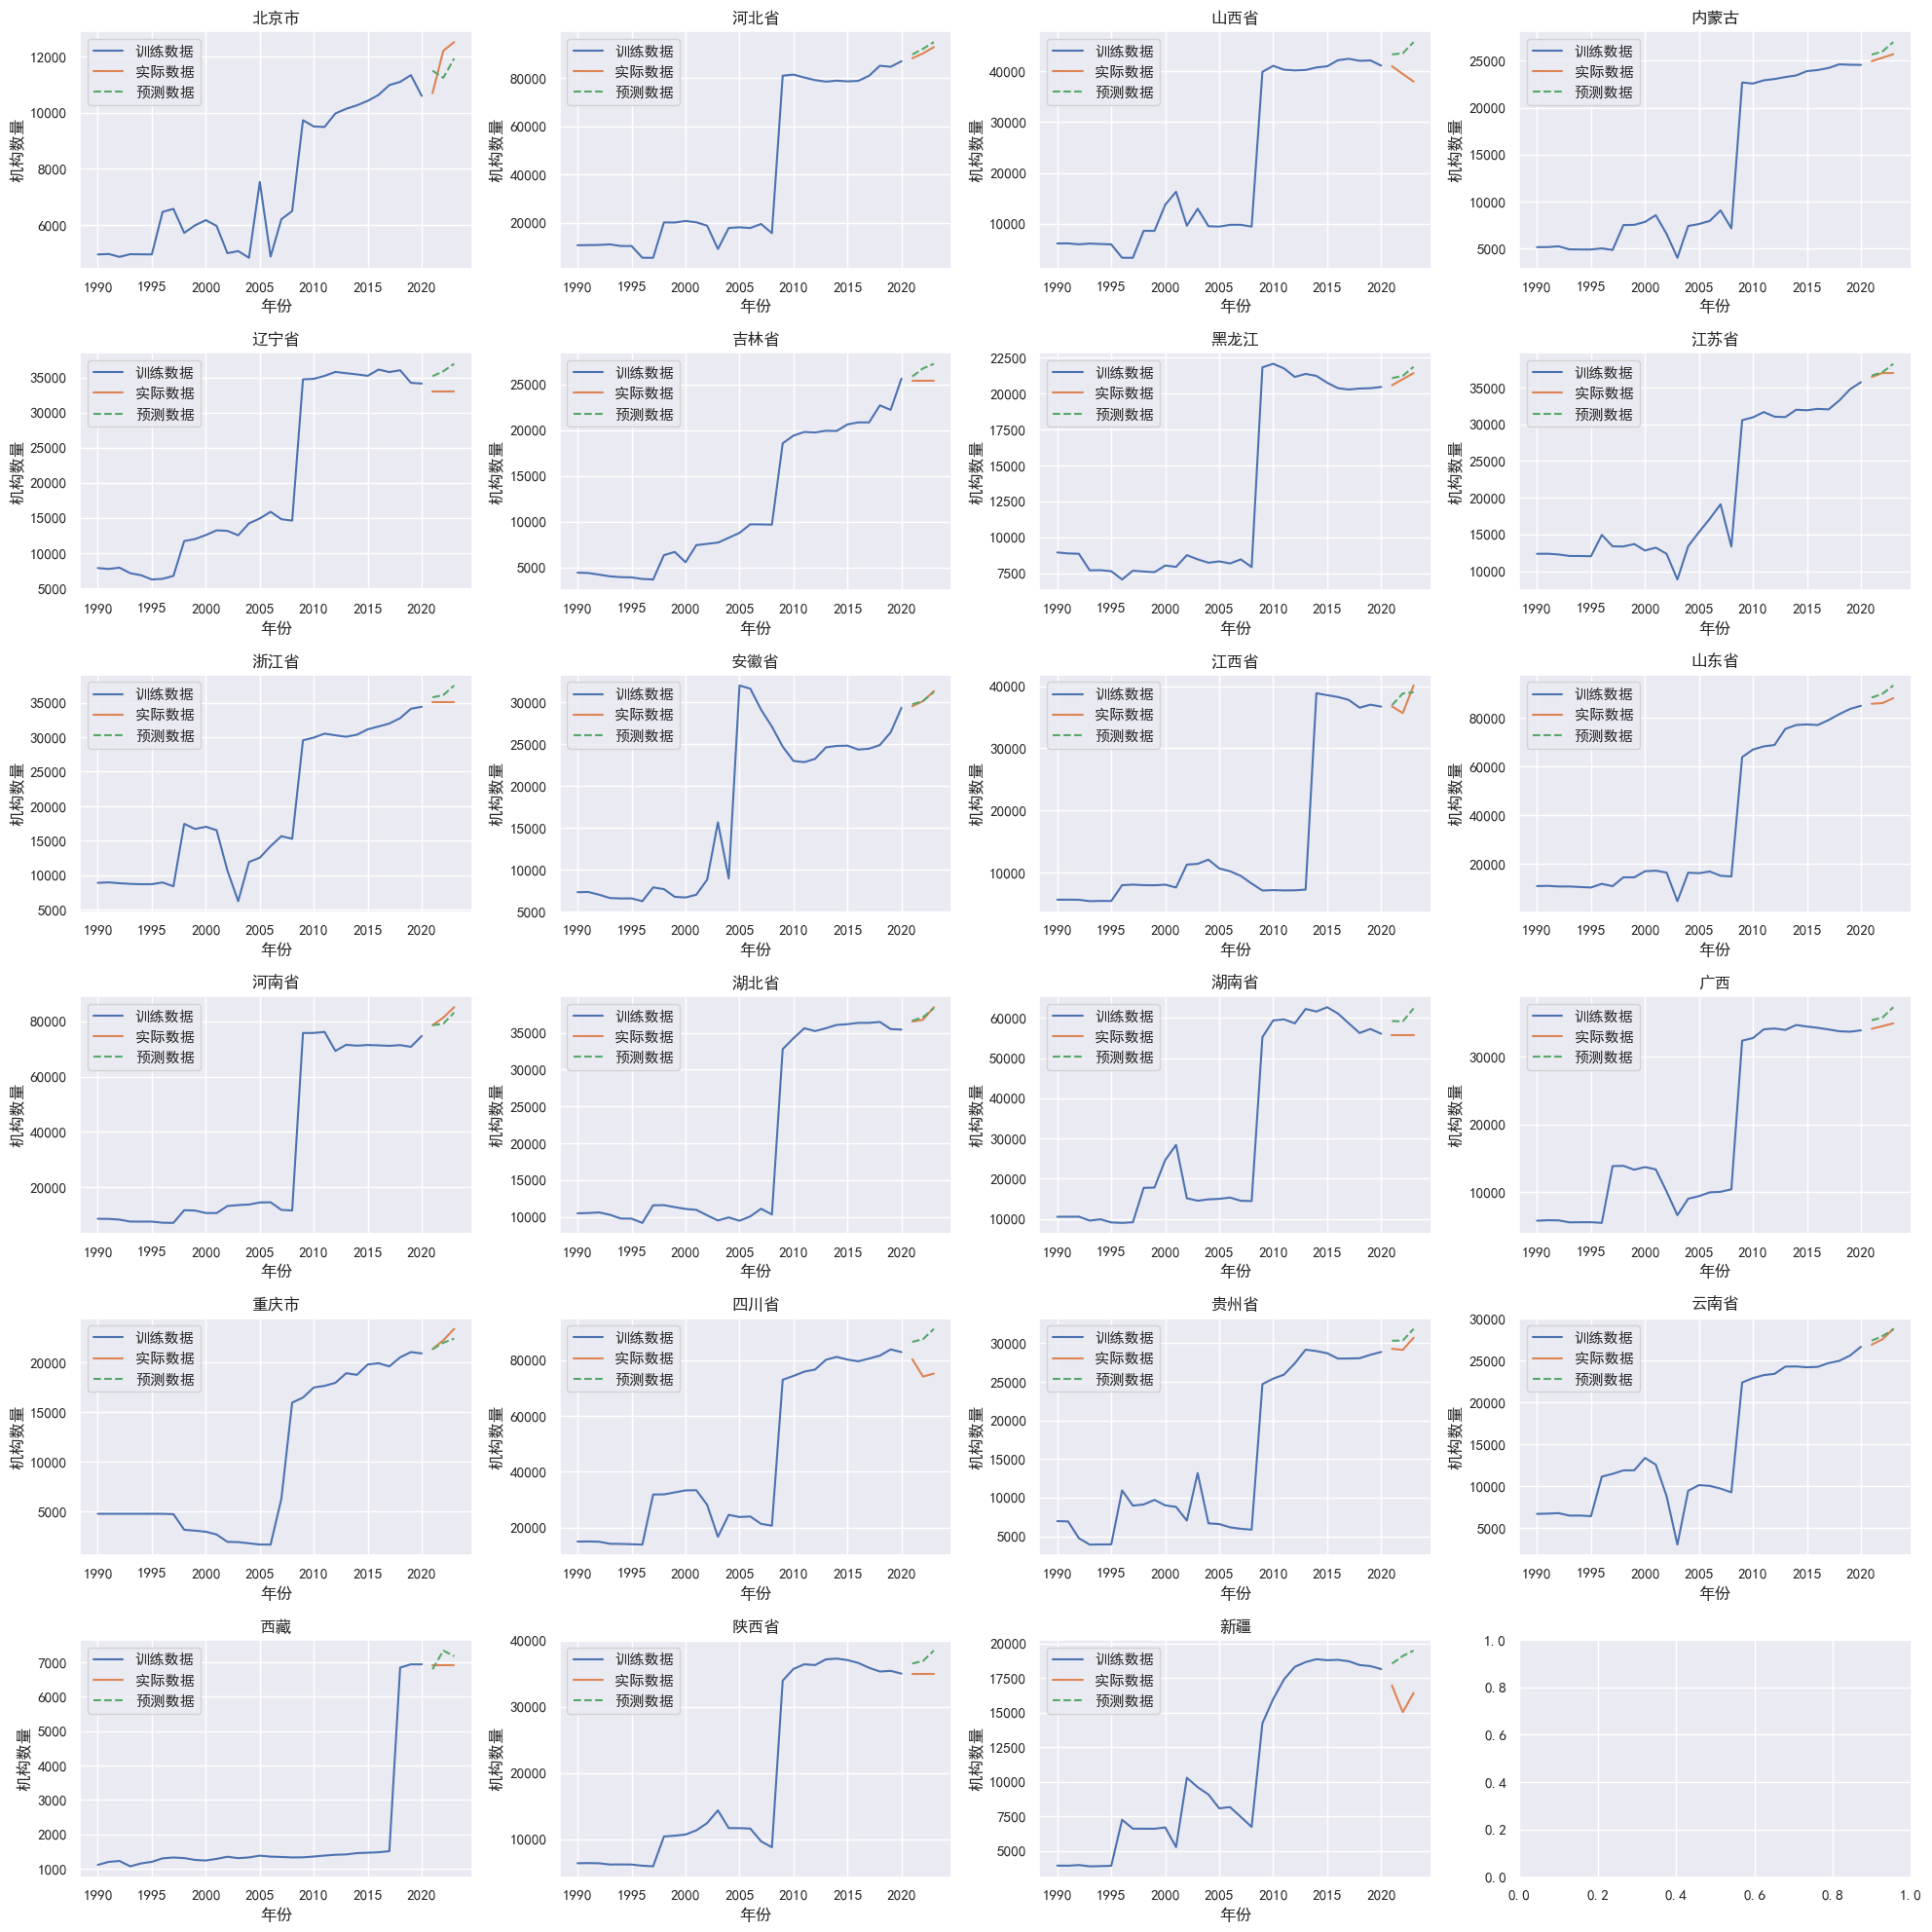

   Region          RMSE           MAE            R2
0     北京市    797.229538    781.870531 -5.452556e-03
1     河北省   1874.286203   1864.302038  3.551261e-02
2     山西省   5242.405199   4726.462928 -1.723667e+01
3     内蒙古    927.121471    880.355019 -8.494882e+00
4     辽宁省   3043.233330   2955.828407 -5.381707e+29
5     吉林省   1383.853310   1259.215757  0.000000e+00
6     黑龙江    402.809181    387.532314 -3.570103e-01
7     江苏省    738.829061    525.915300 -7.032490e+00
8     浙江省   1522.491864   1327.817707  0.000000e+00
9     安徽省    150.077699    111.403923  9.599099e-01
10    江西省   1927.884581   1478.709400 -4.148370e-02
11    山东省   4006.408536   3851.528397 -1.452943e+01
12    河南省   1694.209430   1381.502422  5.959940e-01
13    湖北省    225.693274    202.016252  9.328038e-01
14    湖南省   4788.265387   4544.024125 -4.141363e+29
15     广西   1722.317634   1638.094909 -2.737227e+01
16    重庆市    580.367186    412.415173  5.113761e-01
17    四川省  12558.744370  11858.895164 -2.047518e+01
18    贵州省   

In [62]:
# 评估模型的准确性

# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['北京市', '河北省', '山西省', '内蒙古', '辽宁省', '吉林省', '黑龙江', 
           '江苏省', '浙江省', '安徽省', '江西省', '山东省', '河南省', '湖北省', 
           '湖南省', '广西', '重庆市', '四川省', '贵州省', '云南省', '西藏', '陕西省', '新疆']

# 初始化一个空的DataFrame用于存储评估结果
evaluation_results = pd.DataFrame(columns=['Region', 'RMSE', 'MAE', 'R2'])

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values.reshape(-1, 1)
    
    # 归一化
    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    data_scaled = scaler.fit_transform(data)

    # 分为训练集和测试集
    train_data = data_scaled[:-3]  # 训练集为所有数据，但留出最后3年做测试
    test_data = data_scaled[-3:]   # 最后3年作为测试集

    # 拟合Holt-Winters模型
    model = ExponentialSmoothing(train_data, seasonal='mul', trend='add', seasonal_periods=2)
    fit = model.fit()

    # 预测未来3年
    forecast_scaled = fit.forecast(steps=3)
    
    # 计算误差指标
    r2 = r2_score(test_data, forecast_scaled)

    # 将预测值反归一化回原始尺度
    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    test_data = scaler.inverse_transform(test_data).flatten()

    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, forecast)

    # 存储评估结果
    new_row = pd.DataFrame({
        'Region': [region],
        'RMSE': [rmse],
        'MAE': [mae],
        'R2': [r2],
    })
    evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)
    
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index[:-3], y=scaler.inverse_transform(train_data).flatten(), ax=axes[i], label='训练数据')
    sns.lineplot(x=df.index[-3:], y=test_data, ax=axes[i], label='实际数据')
    sns.lineplot(x=df.index[-3:], y=forecast, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 输出评估结果
print(evaluation_results)

In [69]:
# 展示R2大于0的地区
regions_r2 = evaluation_results.loc[evaluation_results['R2'] > 0.5, :]
print(regions_r2)
print(regions_r2['Region'].tolist())

   Region         RMSE          MAE        R2
9     安徽省   150.077699   111.403923  0.959910
12    河南省  1694.209430  1381.502422  0.595994
13    湖北省   225.693274   202.016252  0.932804
16    重庆市   580.367186   412.415173  0.511376
19    云南省   358.118647   309.674889  0.789342
['安徽省', '河南省', '湖北省', '重庆市', '云南省']


[31713.01071896 32807.81399278 33179.80789862 34292.63695611
 34646.60507828]
[85717.33500879 89697.20151222 90291.01293779 94356.40302247
 94864.69086678]
[38898.99362659 40196.32527475 40583.93513468 41903.65055604
 42268.87664278]
[24040.60228694 24518.51362327 25174.04127418 25648.0272564
 26307.48026142]
[29268.15680143 30059.20729135 30600.62410388 31397.19114189
 31933.09140633]


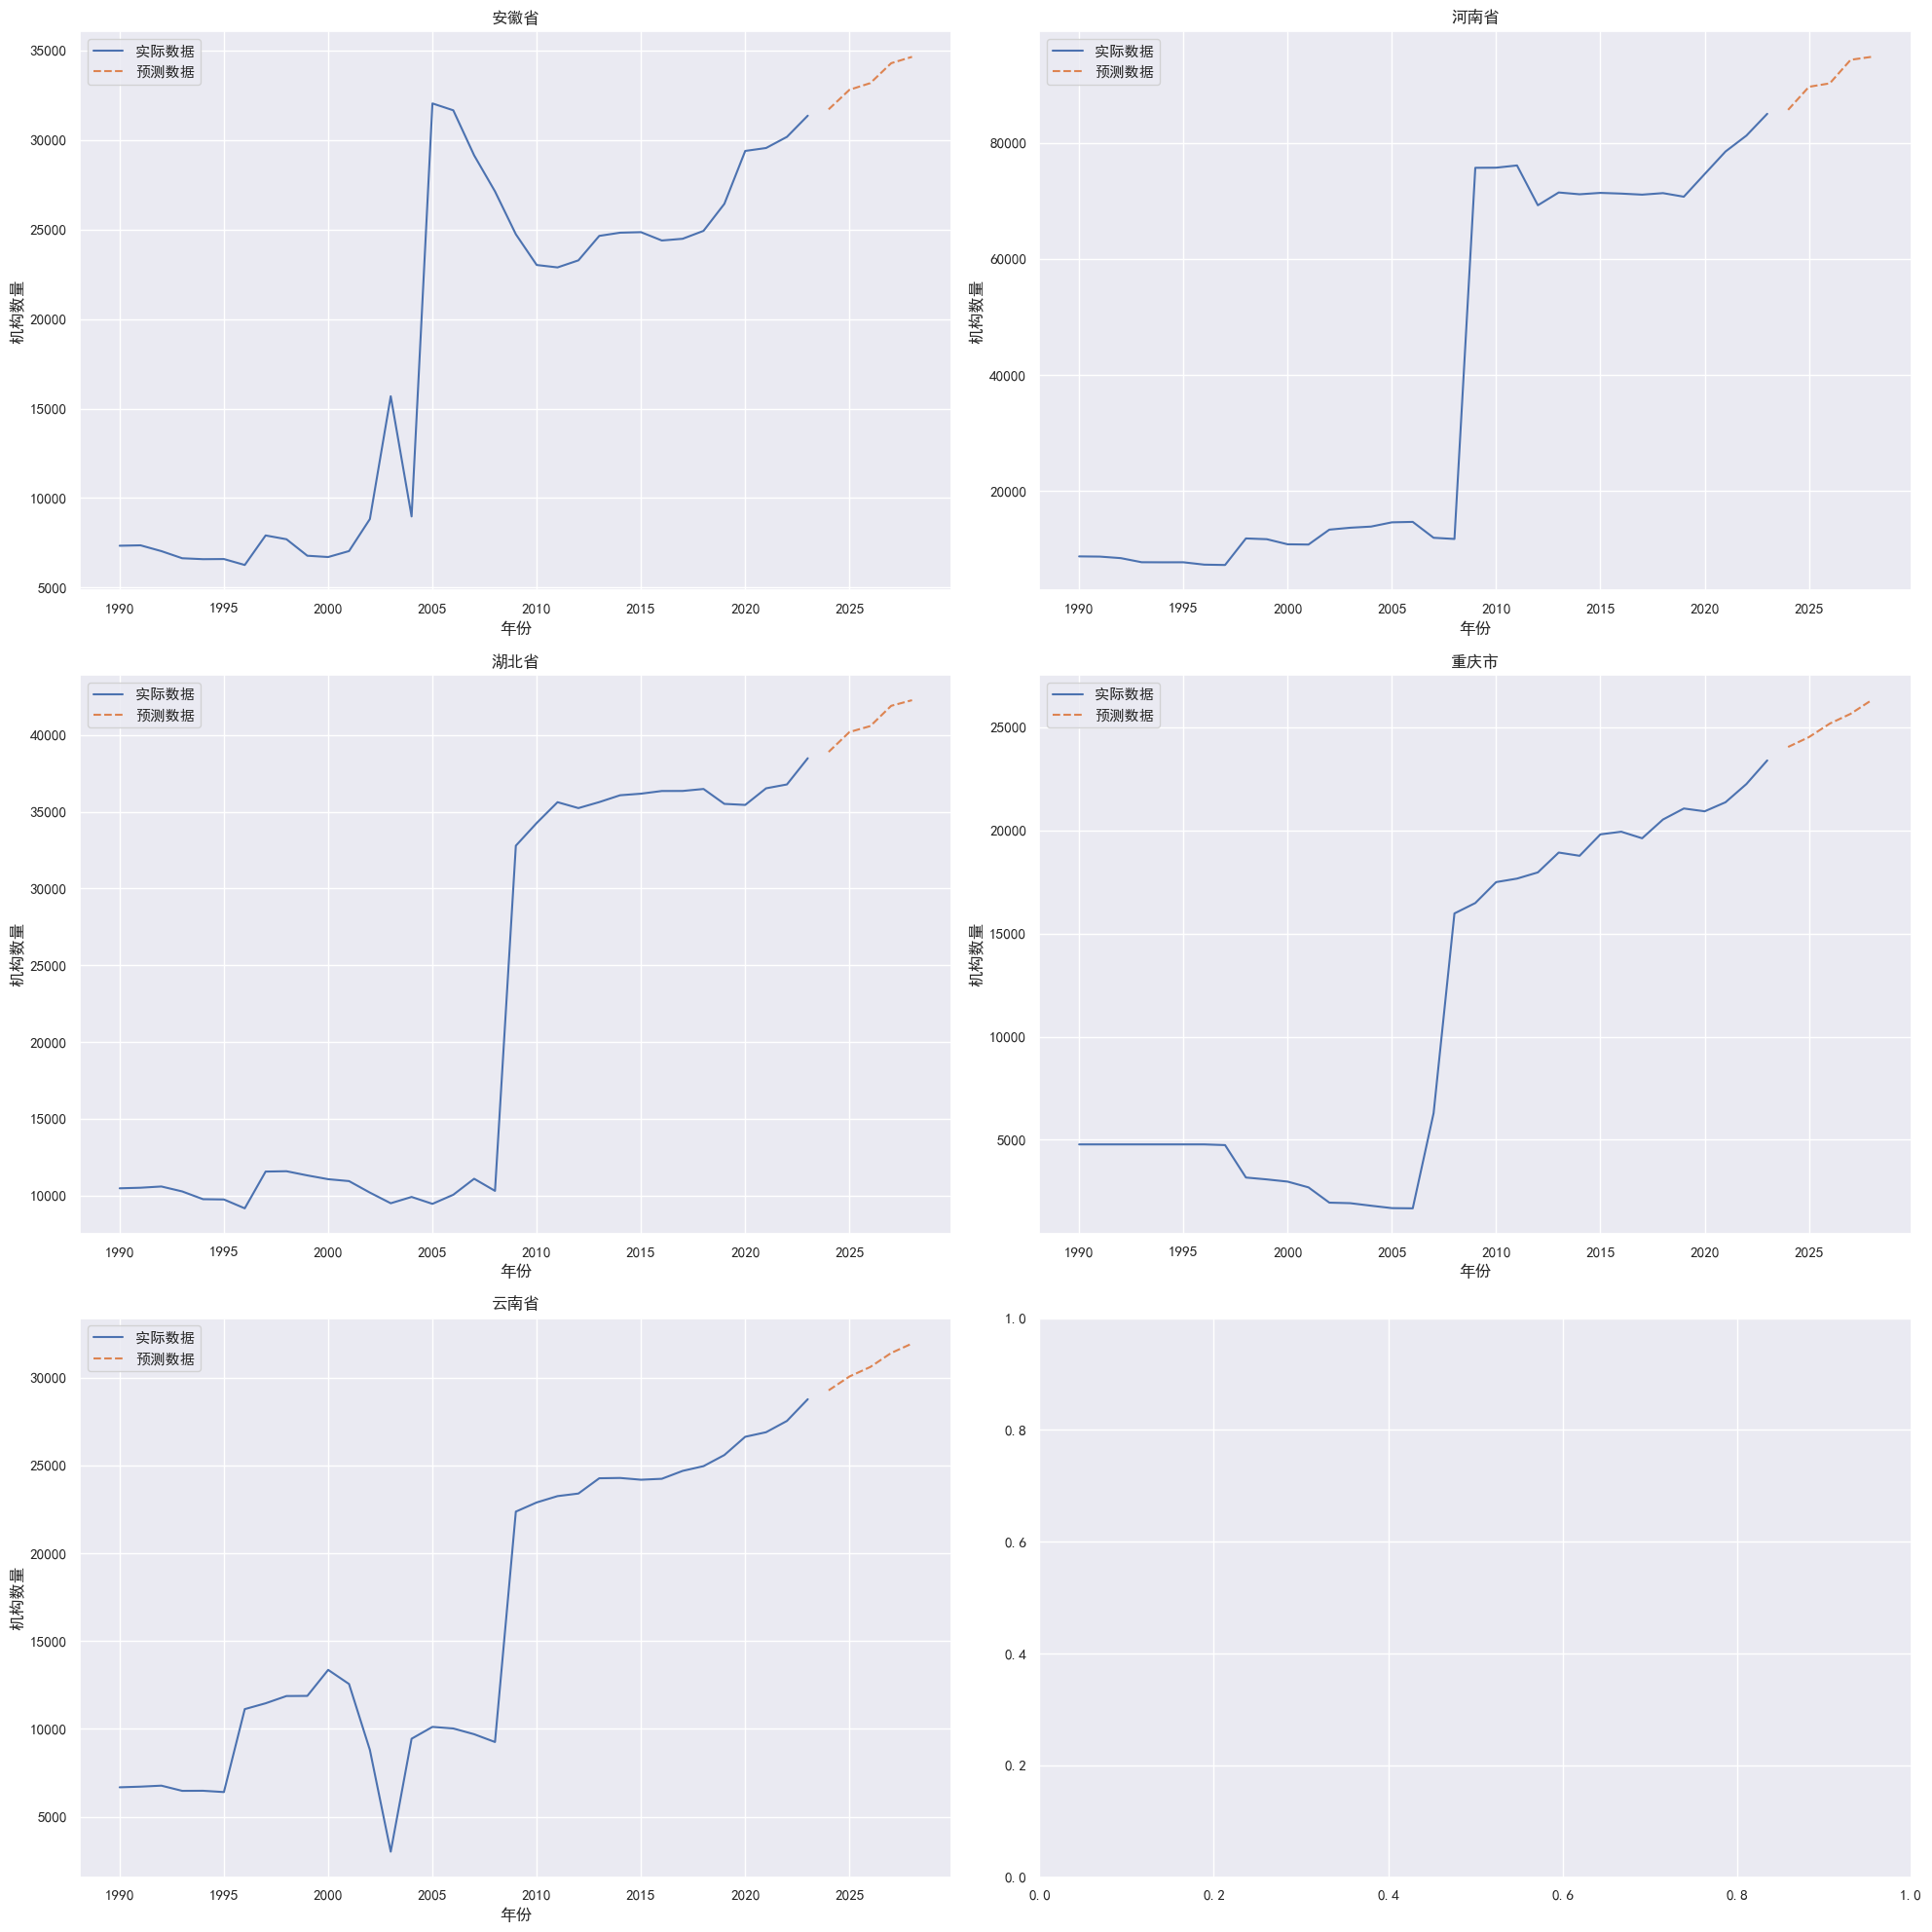

               安徽省           河南省           湖北省           重庆市           云南省
2024  31713.010719  85717.335009  38898.993627  24040.602287  29268.156801
2025  32807.813993  89697.201512  40196.325275  24518.513623  30059.207291
2026  33179.807899  90291.012938  40583.935135  25174.041274  30600.624104
2027  34292.636956  94356.403022  41903.650556  25648.027256  31397.191142
2028  34646.605078  94864.690867  42268.876643  26307.480261  31933.091406


In [77]:
# 针对所选的5个地区，预测后5年的机构数量

# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['安徽省', '河南省', '湖北省', '重庆市', '云南省']

# 预测年份
predict_year = [2024, 2025, 2026, 2027, 2028]

# 创建df来存储预测结果
forecast_df = pd.DataFrame(index=predict_year, columns=regions)

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values.reshape(-1, 1)
    
    # 归一化
    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    data_scaled = scaler.fit_transform(data)

    # 拟合Holt-Winters模型
    model = ExponentialSmoothing(data_scaled, seasonal='mul', trend='add', seasonal_periods=2)
    fit = model.fit()

    # 预测未来3年
    forecast_scaled = fit.forecast(steps=5)

    # 将预测值反归一化回原始尺度
    data = scaler.inverse_transform(data_scaled.reshape(-1, 1)).flatten()
    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    print(forecast)
    
    # 存储预测结果
    s = pd.Series(forecast, index=predict_year)
    forecast_df[region] = s

    # 绘制折线图
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index, y=data, ax=axes[i], label='实际数据')
    sns.lineplot(x=predict_year, y=forecast, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

print(forecast_df)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r3_score

# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['北京市', '河北省', '山西省', '内蒙古', '辽宁省', '吉林省', '黑龙江', 
           '江苏省', '浙江省', '安徽省', '江西省', '山东省', '河南省', '湖北省', 
           '湖南省', '广西', '重庆市', '四川省', '贵州省', '云南省', '西藏', '陕西省', '新疆']

# 初始化一个空的DataFrame用于存储评估结果
evaluation_results = pd.DataFrame(columns=['Region', 'MSE', 'MAE', 'R3'])

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(30, 30))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[[region]].reset_index().rename(columns={'年份': 'ds', region: 'y'})
    
    # 分为训练集和测试集
    train_data = data.iloc[:-3]  # 训练集为所有数据，但留出最后3年做测试
    test_data = data.iloc[-3:]   # 最后3年作为测试集

    # 拟合Prophet模型
    model = Prophet()
    model.fit(train_data)

    # 预测未来3年
    future = model.make_future_dataframe(periods=3, freq='Y')
    forecast = model.predict(future)

    # 提取预测值
    forecast_values = forecast['yhat'].iloc[-3:].values

    # 计算误差指标
    mse = mean_squared_error(test_data['y'], forecast_values)
    mae = mean_absolute_error(test_data['y'], forecast_values)
    r3 = r3_score(test_data['y'], forecast_values)

    # 存储评估结果
    new_row = pd.DataFrame({
        'Region': [region],
        'MSE': [mse],
        'MAE': [mae],
        'R3': [r3],
    })
    evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)

    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=train_data['ds'], y=train_data['y'], ax=axes[i], label='训练数据')
    sns.lineplot(x=test_data['ds'], y=test_data['y'], ax=axes[i], label='实际数据')
    sns.lineplot(x=test_data['ds'], y=forecast_values, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 输出评估结果
print(evaluation_results)


ModuleNotFoundError: No module named 'Prophet'